In [1]:
from attack_metrics import _curvature_metric, _cosine_metric, _curvature_divergence, \
    _entropy_metric, _euclidean_metric, _jacobian_metric, _loss_metric, _hessian_metric
import os, sys
import pandas as pd

In [2]:
import pickle as pk
from Dataset.mnist import MNISTDataset
from lightning import Trainer
from torch.utils.data import DataLoader
import torch 
from Model.mlp import MLP
import numpy as np
from Model.simplemobilenet import SimpleMobileNet

In [3]:
import networkx as nx
import copy

In [4]:
topo_name ="J:/TIA/TIA/topologies/30_ER_0.5.pk"
with open(topo_name, "rb") as f:
    G = pk.load(f)
    
label = nx.adjacency_matrix(G).todense()


In [5]:
scenario_folder = "K:\\TIA\\Mnist_mlp_ER_0.5_1_0.1_42_3_30\\"
train_loader_file = os.path.join(scenario_folder, "train_loaders.pk")
with open(train_loader_file, 'rb') as f:
    train_loaders = pk.load(f)

num = len(train_loaders)

In [6]:
model = MLP()

In [7]:
model_folder = f'{scenario_folder}\\Aggregated_models\\Round_39\\'
clients = []
for node_id in range(num):
    print(f"load model for node: {node_id}")
    client_path = model_folder + f"client_{node_id}.pth"

    if os.path.exists(client_path):                                        
        last_round_params = torch.load(client_path)
    
        client = copy.deepcopy(model)
        client.load_state_dict(last_round_params)
        clients.append(client)

load model for node: 0
load model for node: 1
load model for node: 2
load model for node: 3
load model for node: 4
load model for node: 5
load model for node: 6
load model for node: 7
load model for node: 8
load model for node: 9
load model for node: 10
load model for node: 11
load model for node: 12
load model for node: 13
load model for node: 14
load model for node: 15
load model for node: 16
load model for node: 17
load model for node: 18
load model for node: 19
load model for node: 20
load model for node: 21
load model for node: 22
load model for node: 23
load model for node: 24
load model for node: 25
load model for node: 26
load model for node: 27
load model for node: 28
load model for node: 29


In [8]:
model_folder = f'{scenario_folder}\\Aggregated_models\\Round_38\\'
clients_last = []
for node_id in range(num):
    print(f"load last round model for node: {node_id}")
    client_path = model_folder + f"client_{node_id}.pth"

    if os.path.exists(client_path):                                        
        last_round_params = torch.load(client_path)
    
        client = copy.deepcopy(model)
        client.load_state_dict(last_round_params)
        clients_last.append(client)

load last round model for node: 0
load last round model for node: 1
load last round model for node: 2
load last round model for node: 3
load last round model for node: 4
load last round model for node: 5
load last round model for node: 6
load last round model for node: 7
load last round model for node: 8
load last round model for node: 9
load last round model for node: 10
load last round model for node: 11
load last round model for node: 12
load last round model for node: 13
load last round model for node: 14
load last round model for node: 15
load last round model for node: 16
load last round model for node: 17
load last round model for node: 18
load last round model for node: 19
load last round model for node: 20
load last round model for node: 21
load last round model for node: 22
load last round model for node: 23
load last round model for node: 24
load last round model for node: 25
load last round model for node: 26
load last round model for node: 27
load last round model for node

In [9]:
all_metrics = {}

In [10]:
device = 'cuda'

In [11]:
for approach in ['_curvature_metric', '_cosine_metric', '_curvature_divergence', 
    '_entropy_metric', '_euclidean_metric', '_jacobian_metric', '_loss_metric', '_hessian_metric']:
# for approach in ['_curvature_metric', '_cosine_metric']:
    metrics = []
    for i in range(0, num):
        row = []
        for j in range(0, num):
            clients[i].to(device)
            clients_last[i].to(device)
            clients[j].to(device)
            clients_last[j].to(device)
            if approach == '_curvature_metric':
                m = _curvature_metric(model, clients[j].state_dict(),clients_last[j].state_dict(), train_loaders[i], max_batches=1, approach='approx')
            if approach == '_cosine_metric':
                m =_cosine_metric(clients[i].state_dict(), clients[j].state_dict())
            if approach == '_euclidean_metric':
                m =_euclidean_metric(clients[i].state_dict(), clients[j].state_dict())
                
            if approach == '_hessian_metric':
                m = _hessian_metric(model, clients[j].state_dict(), train_loaders[i], max_batches=1)
            
            if approach == '_jacobian_metric':
                m = _jacobian_metric(model, clients[j].state_dict(), train_loaders[i], max_batches=1)
                
            if approach == '_loss_metric':
                m = _loss_metric(model, clients[j].state_dict(), train_loaders[i], max_batches=1)
                
            if approach == '_entropy_metric':
                m =_entropy_metric(model, clients[j].state_dict(), train_loaders[i], max_batches=1)               
               
            if approach == '_curvature_divergence':
                m =_curvature_divergence(clients[i].state_dict(), clients_last[i].state_dict(), clients[j].state_dict(), clients_last[j].state_dict())
            
            row.append(m)
        metrics.append(row)
    metrics_sm = copy.deepcopy(metrics)
    for i in range(0, num):
        for j in range(0, num):
            metrics_sm[i][j] = (metrics[i][j] + metrics[j][i])/2
    all_metrics[approach]=metrics_sm

j:\TIA\.venv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\engine.cpp:1265.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


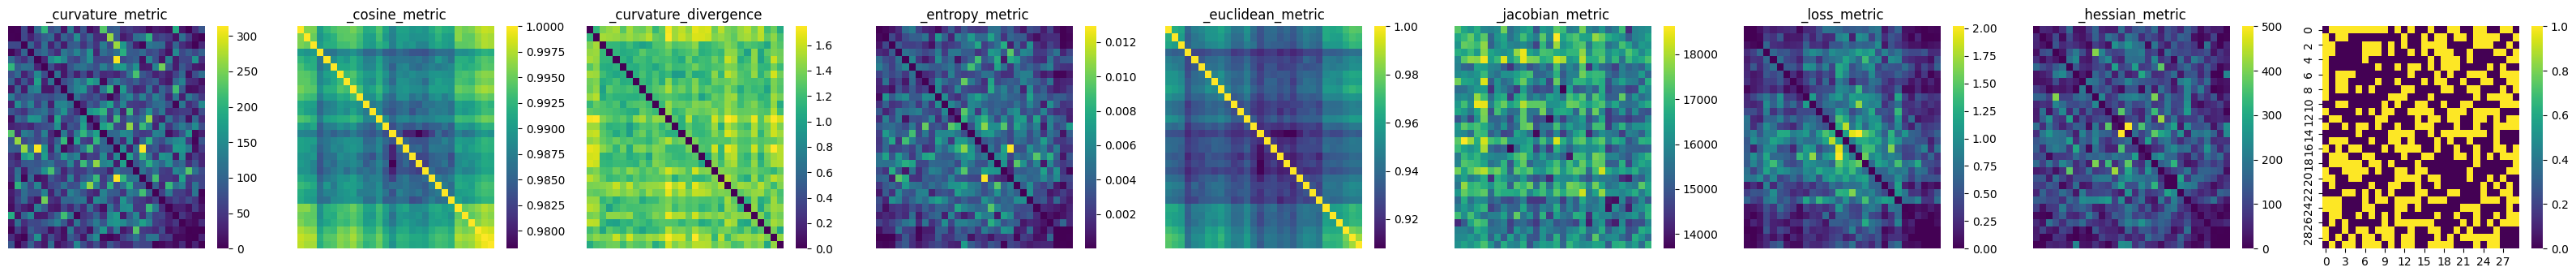

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 9, figsize=(32, 3.5))
for ax, (title, matrix) in zip(axes[0:8], all_metrics.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')
sns.heatmap(label, ax=axes[-1], cmap="viridis", cbar=True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import numpy as np

In [41]:
def _edge_group_clustering(value_ls, clustering_name, flag, multi_dimensional=False):
        if multi_dimensional:
            # Multi-dimensional array for Algo_multi
            node_metrics_array = np.array(value_ls)
        else:
            # Single-dimensional array for Algo_row, Algo_average, Algo_column
            node_metrics_array = np.array(value_ls).reshape(-1, 1)

        if clustering_name == "Kmeans":
            clustering_model = KMeans(n_clusters=2, init='k-means++', n_init=50, random_state=0)
        elif clustering_name == "GMM":
            clustering_model = GaussianMixture(n_components=2, n_init=50, random_state=0)
        elif clustering_name == "Spectral":
            n_neighbors = min(len(node_metrics_array), 10) # Since in some DFL cases with fewer nodes, the data samples do not satisfy the minimum requirements 
                                                           # for spectral clustering, here we apply a minimum setting for n_neighbors.
                                                           
            clustering_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=n_neighbors,  random_state=0)
        else:
            raise ValueError("Unsupported clustering method. Choose from 'Kmeans', 'GMM', or 'Spectral'.")

        if clustering_name == "GMM":
            clustering_model.fit(node_metrics_array)
            labels = clustering_model.predict(node_metrics_array)
        else:
            labels = clustering_model.fit_predict(node_metrics_array)
    
        # Calculate mean for each cluster
        cluster_0_mean = node_metrics_array[labels == 0].mean(axis=0).mean() if multi_dimensional else node_metrics_array[labels == 0].mean()
        cluster_1_mean = node_metrics_array[labels == 1].mean(axis=0).mean() if multi_dimensional else node_metrics_array[labels == 1].mean()
        print(cluster_0_mean,cluster_1_mean )
    
        # Determine edge and non-edge labels based on the flag
        if flag:
            # If using negative node metric, smaller mean should correspond to the non-edge group
            if cluster_0_mean < cluster_1_mean:
                edge_label = 1
                non_edge_label = 0
            else:
                edge_label = 0
                non_edge_label = 1
        else:
            # If using positive, smaller mean should correspond to the edge group
            if cluster_0_mean < cluster_1_mean:
                edge_label = 0
                non_edge_label = 1
            else:
                edge_label = 1
                non_edge_label = 0
        
        # Generate inferred connection list
        inferred_connection = [1 if label == edge_label else 0 for label in labels] # this is a list containing inferred connection, each index value indicating 
                                                                                    # if the current node connecting to this node
        return inferred_connection, labels

In [15]:
value_ls = matrix
clustering_name = "Kmeans"
flag = True

In [16]:
def remove_diag_reshape(matrix):
    matrix = np.copy(matrix)
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("must be n*n matrix")
    
    n = matrix.shape[0]
    mask = ~np.eye(n, dtype=bool)
    
    flattened = matrix[mask]
    return flattened.reshape(n, n - 1)
    

In [17]:
def reconstruct_with_diagonal(flattened, diag_value=0):
    flattened = np.copy(flattened)
    length = len(flattened)
    n = int((1 + np.sqrt(1 + 4 * length)) / 2)
    
    if n * (n - 1) != length:
        raise ValueError("input error")

    matrix = np.empty((n, n), dtype=flattened.dtype)
    mask = ~np.eye(n, dtype=bool)
    matrix[mask] = flattened
    np.fill_diagonal(matrix, diag_value)
    return matrix

In [96]:
def contrastive_normalization_np(sim):
    sim = np.copy(sim)
    col_min = sim.min(axis=0, keepdims=True)

    col_max = sim.max(axis=0, keepdims=True)
    
    # col_max = sim.max(axis=0, keepdims=True)

    eps = 1e-8
    normalized = (sim - col_min) / (col_max - col_min + eps)
    normalized = np.clip(normalized, 0, 1)
    # normalized = (normalized + normalized.T) / 2
    normalized = np.power(normalized, 2)
   
    return normalized

In [94]:
all_metrics.keys()

dict_keys(['_curvature_metric', '_cosine_metric', '_curvature_divergence', '_entropy_metric', '_euclidean_metric', '_jacobian_metric', '_loss_metric', '_hessian_metric'])

In [97]:
pred_adj_all = {}
for k in all_metrics.keys():
    value_ls = copy.deepcopy(all_metrics[k])
    reshaped = remove_diag_reshape(value_ls)
    reshaped = contrastive_normalization_np(reshaped)
    clustering_name = "Kmeans"
    if k in ['_cosine_metric', '_euclidean_metric']:
        flag = True
    infer_con,_  = _edge_group_clustering(reshaped, clustering_name, flag, multi_dimensional=False)
    infer_adj = reconstruct_with_diagonal(infer_con)
    pred_adj_all[k] = infer_adj


0.0990009722059373 0.6760397297199549
0.13592207744153512 0.6826851991582458
0.7052818489538341 0.1694442849316045
0.7053759035484342 0.1214358193666456
0.12780715862551514 0.6849880708535778
0.6467266068762206 0.1603367717614233
0.10313516920551628 0.6404895682340008
0.6928541527487758 0.10083867337247514


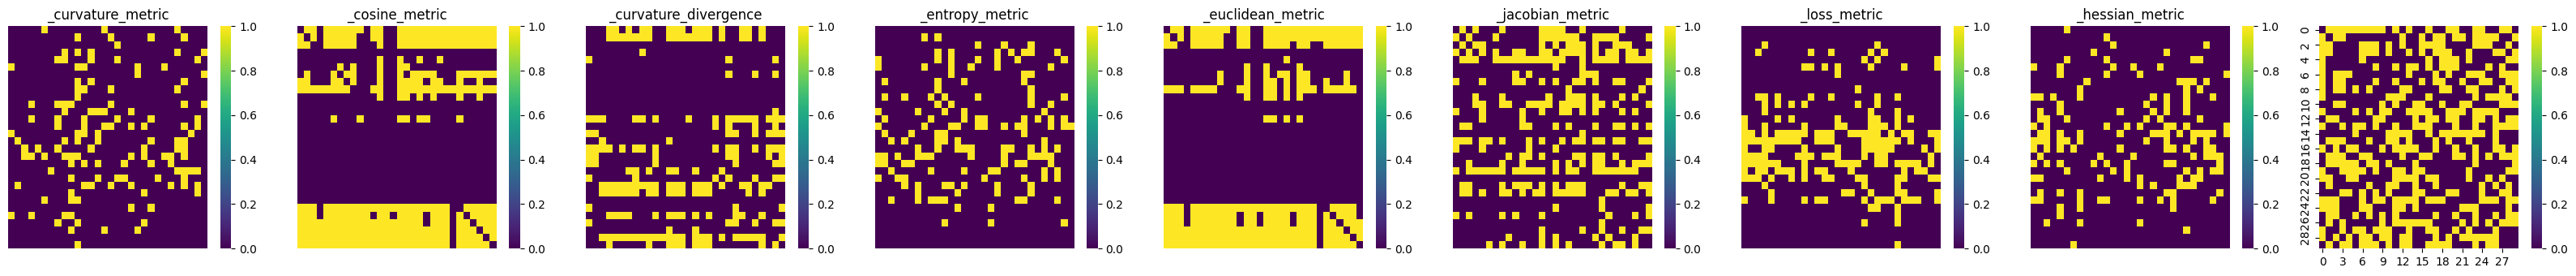

In [98]:
fig, axes = plt.subplots(1, 9, figsize=(32, 3.5))
for ax, (title, matrix) in zip(axes[0:8], pred_adj_all.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')
sns.heatmap(label, ax=axes[-1], cmap="viridis", cbar=True)
plt.tight_layout()
plt.show()

0.06319690012031895 0.48466446833849197
0.08157046737421293 0.5689888001128796
0.16435422567037308 0.6886048637792802
0.5298415510065912 0.0806436082222214
0.0683792920392458 0.5398698106141376
0.6087900233673773 0.14272429258992514
0.055318698543219344 0.46731610783057614
0.4866009588076721 0.05700024790315355


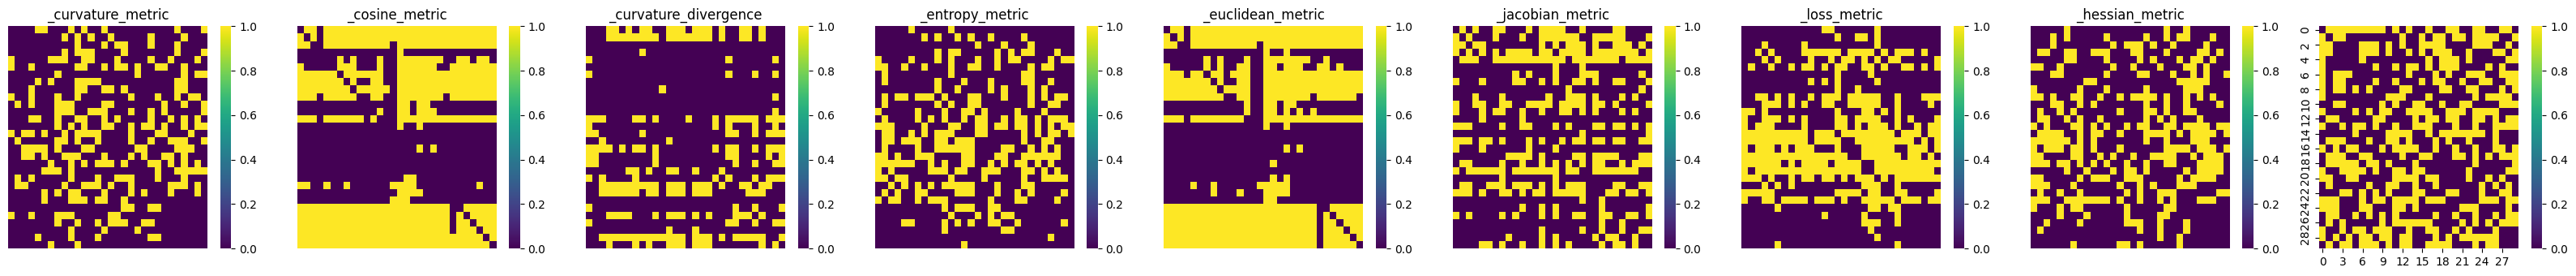

In [99]:
clustering_name = "GMM"

pred_adj_all = {}
for k in all_metrics.keys():
    value_ls = copy.deepcopy(all_metrics[k])
    reshaped = remove_diag_reshape(value_ls)
    reshaped = contrastive_normalization_np(reshaped)
    if k in ['_cosine_metric', '_euclidean_metric']:
        flag = True
    infer_con, _  = _edge_group_clustering(reshaped, clustering_name, flag, multi_dimensional=False)
    infer_adj = reconstruct_with_diagonal(infer_con)
    pred_adj_all[k] = infer_adj
    
fig, axes = plt.subplots(1, 9, figsize=(32, 3.5))
for ax, (title, matrix) in zip(axes[0:8], pred_adj_all.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')
sns.heatmap(label, ax=axes[-1], cmap="viridis", cbar=True)
plt.tight_layout()
plt.show() 

0.32633357390633655 0.025255940249662392
0.5903129059820257 0.08980081944613906


j:\TIA\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.18041817437861918 0.7406140319879332


j:\TIA\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.18880568441384488 0.9937842965306475
0.06942781982923742 0.5431671672655769


j:\TIA\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.4449718998355326 0.05732987479221722


j:\TIA\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.014431365971882125 0.32088248459483437


j:\TIA\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.08901037023595677 0.6344996581538132


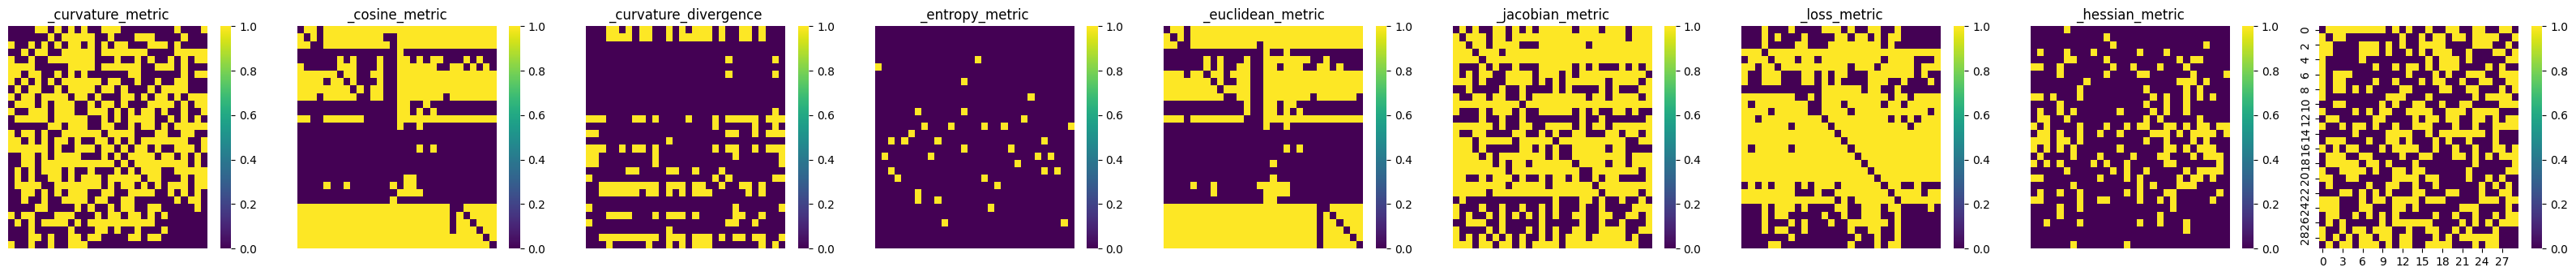

In [100]:
clustering_name = "Spectral"

pred_adj_all = {}
for k in all_metrics.keys():
    value_ls = copy.deepcopy(all_metrics[k])
    reshaped = remove_diag_reshape(value_ls)
    reshaped = contrastive_normalization_np(reshaped)
    if k in ['_cosine_metric', '_euclidean_metric']:
        flag = True
    infer_con, _  = _edge_group_clustering(reshaped, clustering_name, flag, multi_dimensional=False)
    infer_adj = reconstruct_with_diagonal(infer_con)
    pred_adj_all[k] = infer_adj
    
fig, axes = plt.subplots(1, 9, figsize=(32, 3.5))
for ax, (title, matrix) in zip(axes[0:8], pred_adj_all.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')
sns.heatmap(label, ax=axes[-1], cmap="viridis", cbar=True)
plt.tight_layout()
plt.show() 

In [49]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
import pandas as pd

In [87]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, out_channels, heads=1, concat=False)
        self.norm = torch.nn.LayerNorm(out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = self.norm(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, Z):
        N = Z.shape[0]
        pairs = torch.stack(torch.meshgrid(torch.arange(N), torch.arange(N)), dim=-1).reshape(-1, 2)
        zi = Z[pairs[:, 0]]
        zj = Z[pairs[:, 1]]
        z_concat = torch.cat([zi, zj], dim=1)
        pred = self.mlp(z_concat).view(N, N)
        return pred

class GAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        # adj_pred = torch.sigmoid(torch.matmul(z, z.T)) 
        adj_pred = self.decoder(z)
        return adj_pred
    
    

In [67]:
from skimage.filters import threshold_otsu

def threshold_by_otsu(adj_pred):
    if hasattr(adj_pred, 'detach'):
        adj_np = adj_pred.detach().cpu().numpy().flatten()
    else:
        adj_np = adj_pred.flatten()
    threshold = threshold_otsu(adj_np)

    edge_matrix = (adj_pred <= threshold).float()
    return edge_matrix, threshold

In [52]:
def sigmoid_stretch(x, alpha=10):
    return 1 / (1 + np.exp(-alpha * (x - 0.5)))

In [77]:
import numpy as np

# Reconvert matrix using numpy
def contrastive_normalization_np_withpower(sim, eta=3):
    sim = np.copy(sim)
    col_min = sim.min(axis=0, keepdims=True)

    # Sort each column and get the second largest value
    sorted_cols = np.sort(sim, axis=0)
    second_max = sorted_cols[-2, :].reshape(1, -1)
    
    # col_max = sim.max(axis=0, keepdims=True)

    eps = 1e-8
    normalized = (sim - col_min) / (second_max - col_min + eps)

    normalized = np.clip(normalized, 0, 1)
    normalized = (normalized + normalized.T) / 2
    normalized = np.power(normalized, eta)
    
    return normalized

# Redefine transformation functions using NumPy
def amplify_similarity_np(sim, gamma=5):
    return (1.0 - sim) ** gamma 

In [54]:
def build_sparse_edge_otsu(sim_matrix):
    """
    使用 Otsu 自动阈值从相似度矩阵构建稀疏 edge_index 和 edge_weight。
    输入：
        sim_matrix: torch.Tensor, shape [N, N]，应为对称相似度矩阵
    输出：
        edge_index: torch.LongTensor, shape [2, E]
        edge_weight: torch.FloatTensor, shape [E]
    """
    N = sim_matrix.shape[0]

    # 转为 numpy 计算 otsu 阈值
    sim_np = sim_matrix.cpu().numpy()
    threshold = threshold_otsu(sim_np.flatten())

    edge_index = []
    edge_weight = []

    for i in range(N):
        for j in range(N):
            if i != j and sim_np[i, j] >= threshold:
            # if sim_np[i, j] >= threshold:
                edge_index.append([i, j])
                edge_weight.append(sim_np[i, j].item())

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, E]
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)  # shape [E]

    return edge_index, edge_weight, threshold

In [56]:
all_metrics.keys()
df = all_metrics['_curvature_metric']

In [88]:
sim_matrix_np = np.copy(df)
sim_matrix_np = contrastive_normalization_np(sim_matrix_np)
sim_matrix = torch.tensor(sim_matrix_np, dtype=torch.float32)
x = sim_matrix
# edge_index, edge_weight = build_sparse_edge(sim_matrix)
edge_index, edge_weight, sparse_th = build_sparse_edge_otsu(sim_matrix)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

In [89]:
encoder = GATEncoder(in_channels=x.size(1), hidden_channels=32, out_channels=16)
decoder = Decoder(input_dim=16)
model = GAE(encoder, decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [82]:
def masked_bce_loss(pred, target):
    mask = ~torch.eye(pred.size(0), dtype=torch.bool, device=pred.device)
    loss = F.binary_cross_entropy(pred[mask], target[mask])
    return loss

In [101]:
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    adj_pred = model(data.x, data.edge_index)
    loss = F.mse_loss(adj_pred, sim_matrix)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.0656


In [102]:
model.eval()
with torch.no_grad():
    adj_pred = model(data.x, data.edge_index)
    # edge_matrix, threshold = threshold_by_knee(adj_pred)
    # adj_pred = soft_threshold(adj_pred, tau=0.7)
    edge_matrix, threshold = threshold_by_otsu(adj_pred)

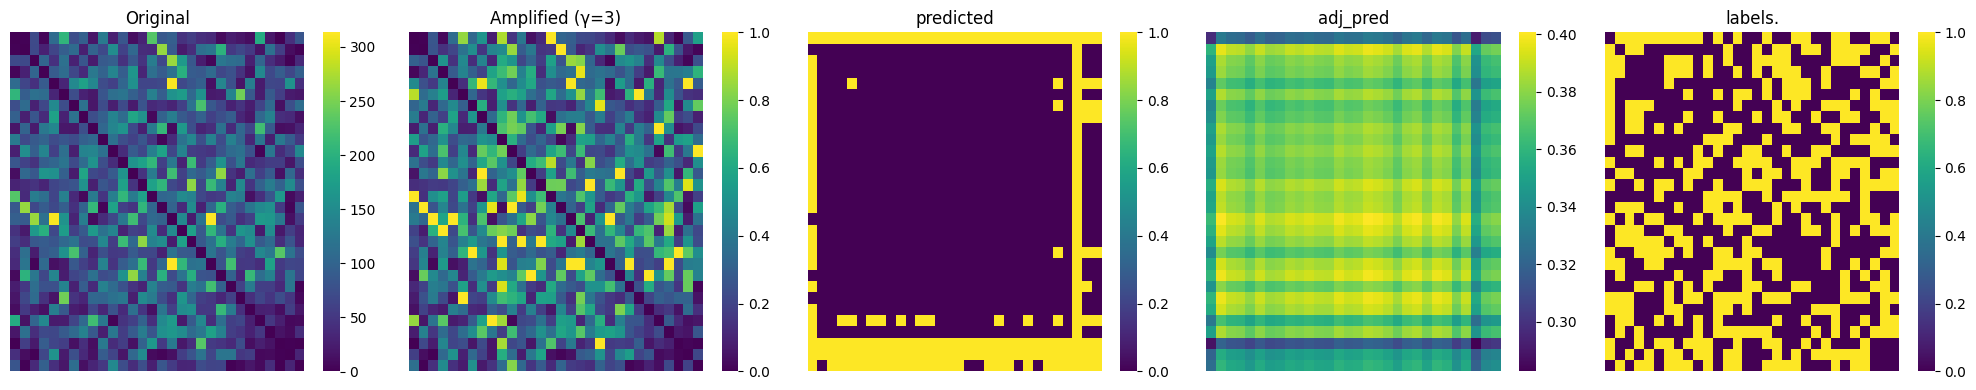

In [103]:
# Switch to using only NumPy for compatibility
import numpy as np

# Reconvert matrix using numpy
# sim_matrix_np = df.values.astype(np.float32)


# Apply transformations
methods_np = {
    "Original": df,
    "Amplified (γ=3)": sim_matrix,
    "predicted": edge_matrix,
    "adj_pred": adj_pred,
    "labels.": label,
}

# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(methods_np), figsize=(20, 4))
for ax, (title, matrix) in zip(axes, methods_np.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
